<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-deepar"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [ ]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

# Install pip packages

In [ ]:
!pip install mxnet
!pip install gluonts

# Select Task

In [4]:
task = 9

In [5]:
import pandas as pd

predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR164', 'VAR169', 'VAR175', 'VAR178', 'VAR228']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task+1}/train{task+1}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

In [6]:
solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)
train_data

,ZONEID 1,ZONEID 2,ZONEID 3
TIMESTAMP,,,
2012-04-01 01:00:00,0.754103,0.647328,0.799000
2012-04-01 02:00:00,0.555000,0.621822,0.817500
2012-04-01 03:00:00,0.438397,0.472692,0.571500
2012-04-01 04:00:00,0.145449,0.098866,0.063775
2012-04-01 05:00:00,0.111987,0.104393,0.103700
...,...,...,...
2013-12-31 20:00:00,0.044936,0.038279,0.037300
2013-12-31 21:00:00,0.159936,0.099676,0.174600
2013-12-31 22:00:00,0.289487,0.239271,0.352550


In [7]:
def get_predictor_ids():
    return ['VAR169', 'VAR175', 'VAR178', 'VAR228', 'VAR164']
def get_predictor_names(i):
    return [f'SSRD {i}', f'STRD {i}', f'TSR {i}', f'TP {i}', f'TCC {i}']

# add total cloud cover * surface solar radiation predictor
# predictors['VAR164*169'] = predictors['VAR164'] * predictors['VAR169']

In [8]:
predictors_categories = [predictors[predictors['ZONEID'] == i][get_predictor_ids()]
                             .rename(dict(zip(get_predictor_ids(), get_predictor_names(i))), 
                                     axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)

In [9]:
for i in range(1, 4):
    for name in get_predictor_names(i):
        predictor_data[name] /= predictor_data[name].max()
predictor_data

,SSRD 1,STRD 1,TSR 1,TP 1,TCC 1,SSRD 2,STRD 2,TSR 2,TP 2,TCC 2,SSRD 3,STRD 3,TSR 3,TP 3,TCC 3
TIMESTAMP,,,,,,,,,,,,,,,
2012-04-01 01:00:00,0.075407,0.035187,0.076927,0.000000,0.244599,0.075759,0.035046,0.077026,0.000000,0.190965,0.075711,0.034431,0.076928,0.000000,0.238145
2012-04-01 02:00:00,0.156676,0.071594,0.159924,0.000000,0.457135,0.156900,0.071159,0.159798,0.000000,0.517131,0.155482,0.069591,0.158553,0.013823,0.561610
2012-04-01 03:00:00,0.231728,0.107719,0.240292,0.028372,0.771424,0.229395,0.107119,0.238421,0.024993,0.705216,0.224083,0.104972,0.233886,0.029863,0.661607
2012-04-01 04:00:00,0.288440,0.144007,0.304604,0.052930,0.965860,0.283726,0.143616,0.300619,0.034330,0.993355,0.279421,0.140904,0.296348,0.037236,0.941552
2012-04-01 05:00:00,0.325958,0.183008,0.352287,0.070487,0.944662,0.322675,0.182606,0.349239,0.041639,0.937597,0.321094,0.178785,0.346746,0.045280,0.944677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 20:00:00,0.744551,0.684306,0.734685,0.001617,0.163548,0.742780,0.682920,0.735453,0.001831,0.410891,0.740352,0.672238,0.735102,0.001926,0.670502
2013-12-31 21:00:00,0.772470,0.718138,0.766252,0.001687,0.114379,0.770181,0.716648,0.766536,0.001895,0.260466,0.767240,0.705250,0.765509,0.001926,0.565792
2013-12-31 22:00:00,0.825222,0.751265,0.820998,0.001687,0.360258,0.822396,0.749118,0.820706,0.001895,0.885766,0.818612,0.736932,0.818764,0.001926,0.982506


In [10]:
# define the parameters of the dataset
gefcom14_metadata = {'num_series': 3,
                     'num_steps': len(predictor_data),
                     'prediction_length': len(benchmark) // 3, # three different timezones
                     'freq': '1H',
                     'start': [pd.Timestamp(predictor_data.index[0], freq='1H') for _ in range(3)]
                     }

In [11]:
targets = [train_data[:-gefcom14_metadata['prediction_length']][f'ZONEID {i}'].values for i in [1,2,3]]
starts = gefcom14_metadata['start']
features = [predictor_data[:-gefcom14_metadata['prediction_length']][get_predictor_names(i)].values.T for i in [1,2,3]]

In [12]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([{
    FieldName.TARGET: target,
    FieldName.START: start,
    FieldName.FEAT_DYNAMIC_REAL: fdr,
    FieldName.FEAT_STATIC_CAT: [fsc]
  } for (target, start, fdr, fsc) in zip(targets, starts, features, [1,2,3])], 
  freq=gefcom14_metadata['freq'])

c:\users\pavel\documents\gefcom14-s-comparison\venv\lib\site-packages\gluonts\json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [13]:
targets = [train_data[f'ZONEID {i}'].values for i in [1,2,3]]
starts = gefcom14_metadata['start']
features = [predictor_data[get_predictor_names(i)].values.T for i in [1,2,3]]

In [14]:
test_ds = ListDataset([{
    FieldName.TARGET: target,
    FieldName.START: start,
    FieldName.FEAT_DYNAMIC_REAL: fdr,
    FieldName.FEAT_STATIC_CAT: [fsc]
  } for (target, start, fdr, fsc) in zip(targets, starts, features, [1,2,3])], 
  freq=gefcom14_metadata['freq'])

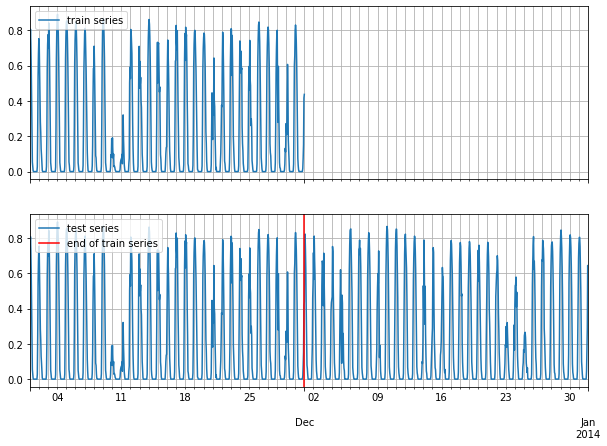

In [15]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

train_series = to_pandas(train_entry)
test_series = to_pandas(test_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series[-24*30:].plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series[-24*30-gefcom14_metadata['prediction_length']:].plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [16]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.mx.distribution import PiecewiseLinearOutput

estimator = DeepAREstimator(freq=gefcom14_metadata['freq'],
                            prediction_length=gefcom14_metadata['prediction_length'],
                            distr_output=PiecewiseLinearOutput(num_pieces=3), # SQF-RNN
                            use_feat_dynamic_real=True,
                            trainer=Trainer(epochs=7))

ensemble_count = 1
predictors = []

for _ in range(ensemble_count):
    predictor = estimator.train(train_ds)
    predictors.append(predictor)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [01:24<00:00,  1.70s/it, epoch=7/7, avg_epoch_loss=0.0232]


In [17]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm import tqdm

forecast_ensemble = []
tss_ensemble = []

for predictor in tqdm(predictors):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=500,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    forecast_ensemble.append(forecasts)
    tss_ensemble.append(tss)

100%|██████████| 1/1 [00:34<00:00, 34.34s/it]


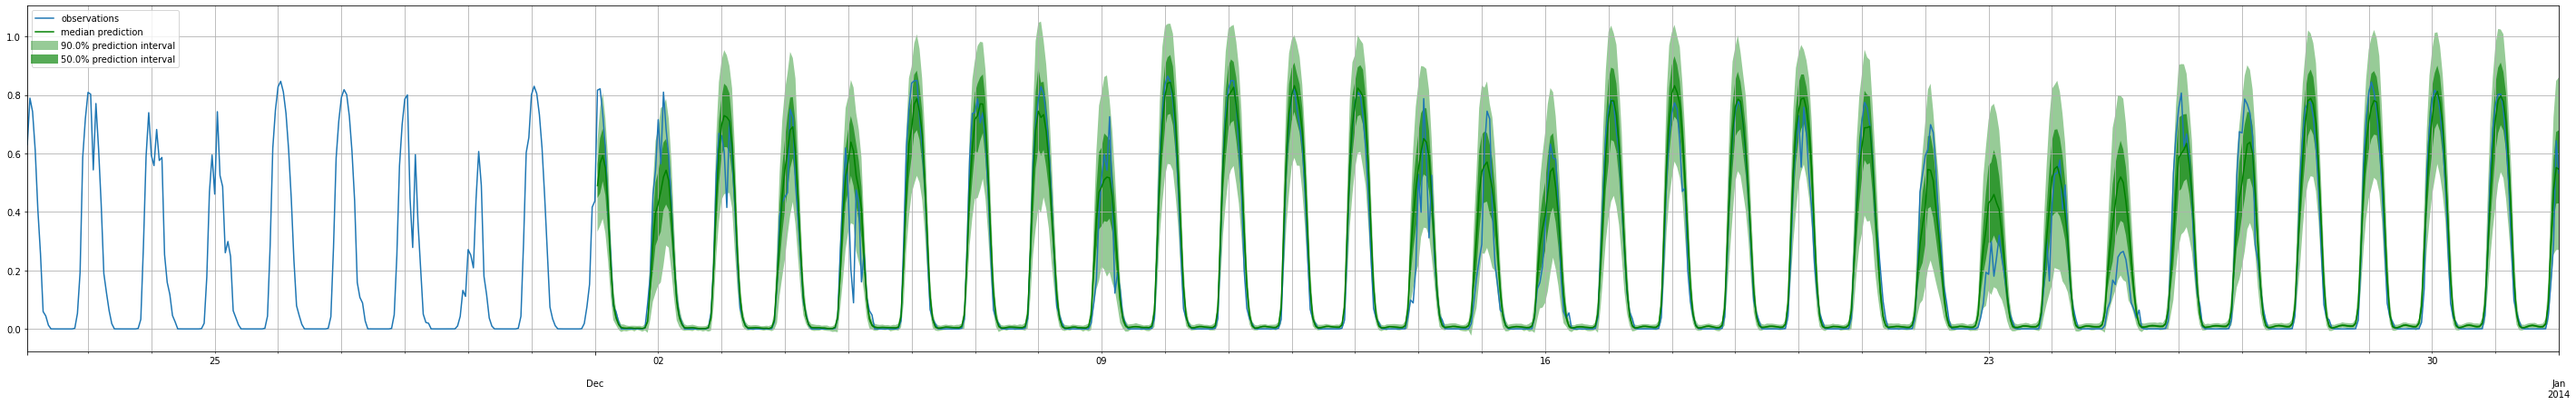

In [18]:
def plot_prob_forecasts(ts_entry, forecast_entry, output_file=None):
    plot_length = 24 * 40
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(50, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    if output_file is not None:
        plt.savefig(output_file)
    plt.show()

plot_prob_forecasts(tss[0], forecasts[0])

In [20]:
import numpy as np

prediction_ensemble = []

for forecasts in forecast_ensemble:
    zone_predictions = []
    for i, forecast in enumerate(forecasts):
        prediction = pd.concat([np.maximum(forecast.quantile_ts(p/100), 0)
                                for p in range(1, 100)], axis=1)\
            .rename(columns={p: str((p+1)/100) for p in range(99)})
        prediction.insert(0, 'ZONEID', i+1)
        prediction.index.name = 'TIMESTAMP'
        zone_predictions.append(prediction)

    predictions = pd.concat(zone_predictions)
    prediction_ensemble.append(predictions)

In [21]:
averaged_predictions = pd.DataFrame()

for p in range(1, 100):
    quantile_columns = [prediction[str(p/100)] for prediction in prediction_ensemble]
    averaged_predictions.insert(p-1, str(p/100), np.mean(quantile_columns, axis=0))

averaged_predictions.insert(0, 'ZONEID', np.array(prediction_ensemble[0]['ZONEID']))
averaged_predictions.insert(0, 'TIMESTAMP', prediction_ensemble[0].index)
averaged_predictions = averaged_predictions.set_index('TIMESTAMP')

averaged_predictions

,ZONEID,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2013-12-01 01:00:00,1,0.291754,0.301320,0.314663,0.319016,0.332447,0.342872,0.348659,0.357405,0.361620,...,0.621815,0.627812,0.631021,0.634637,0.637850,0.642602,0.645621,0.649245,0.655053,0.656801
2013-12-01 02:00:00,1,0.305342,0.326675,0.337275,0.344788,0.352221,0.358315,0.368792,0.377105,0.383354,...,0.724244,0.731278,0.739321,0.748699,0.755356,0.758210,0.763743,0.778717,0.796703,0.814687
2013-12-01 03:00:00,1,0.260013,0.288499,0.317288,0.359901,0.376689,0.384266,0.394615,0.401298,0.406667,...,0.766367,0.775940,0.784826,0.795834,0.801927,0.808118,0.822522,0.828673,0.840511,0.854275
2013-12-01 04:00:00,1,0.224388,0.267006,0.286020,0.313711,0.327258,0.338912,0.348217,0.357222,0.365853,...,0.686350,0.691304,0.696071,0.703476,0.707748,0.720529,0.727398,0.741551,0.758129,0.790214
2013-12-01 05:00:00,1,0.155264,0.179474,0.198477,0.220286,0.234246,0.241609,0.253216,0.256070,0.260655,...,0.547642,0.552135,0.558496,0.570231,0.575495,0.585969,0.591558,0.597219,0.608828,0.627242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 20:00:00,3,0.003417,0.011617,0.017665,0.026822,0.031939,0.032967,0.034228,0.037877,0.041824,...,0.179350,0.184317,0.186605,0.191358,0.199521,0.203324,0.206232,0.213874,0.224828,0.237942
2013-12-31 21:00:00,3,0.063889,0.082519,0.086166,0.098978,0.103310,0.107402,0.115081,0.123006,0.127198,...,0.430926,0.441904,0.446426,0.455439,0.461574,0.472505,0.483540,0.494927,0.532943,0.566984
2013-12-31 22:00:00,3,0.084343,0.104825,0.121970,0.131820,0.139029,0.149206,0.164288,0.170503,0.172319,...,0.601760,0.607681,0.620931,0.638984,0.651882,0.676656,0.698368,0.708252,0.729279,0.769927


In [22]:
!mkdir -p results

In [23]:
averaged_predictions.to_csv(f'results/prediction_sqf_rnn_task{task}.csv')

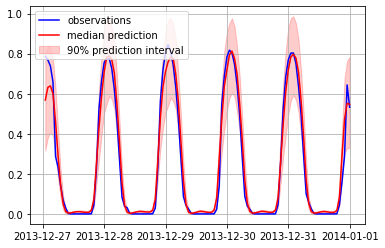

In [29]:
import matplotlib.pyplot as plt

def plot_prob_forecasts(target, forecast, output_file=None):
    prediction_length = 5 * 24
    prediction_intervals = (50, 90)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    plt.plot(target[-prediction_length:], 'b')
    for p in prediction_intervals:
        if p != 50:
            lower = forecast[str(p/100)]
            upper = forecast[str((100-p)/100)]

            plt.fill_between(
                target[-prediction_length:].index, lower[-prediction_length:], upper[-prediction_length:], alpha=0.2, color="r",
                label="Pred. interval")
        else:
            median = forecast[str(p/100)]
            plt.plot(target[-prediction_length:].index, median[-prediction_length:], 'r')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    if output_file is not None:
        plt.savefig(output_file)
    plt.show()

target = tss[0]
forecast = averaged_predictions[averaged_predictions['ZONEID'] == 1]
plot_prob_forecasts(target, forecast, output_file=f'sqf_rnn_plot_{task}.pdf')

## Plotting the quantile prediction for the first entries

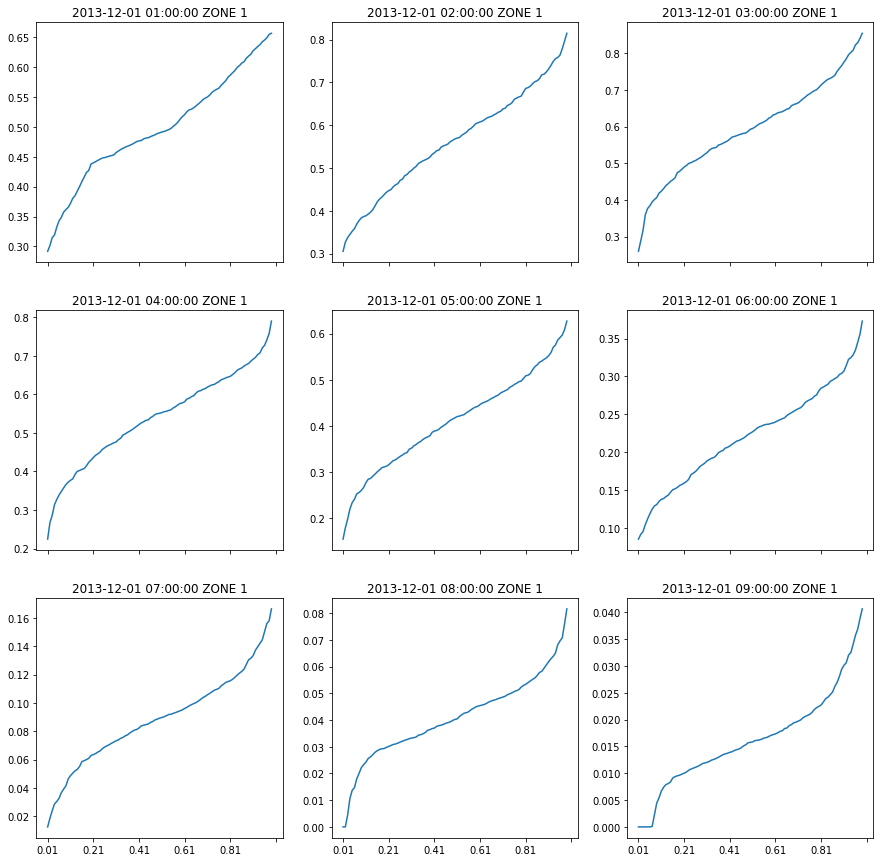

In [30]:
fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    predictions.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3], 
                                      title=str(predictions.index[i]) + ' ZONE ' 
                                      + str(int(predictions.iloc[i]['ZONEID'])))

# Evaluate Loss

The loss function is the pinnball loss: 
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [31]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction, 
                    (1 - percentiles / 100) * (prediction - actual), 
                    percentiles / 100 * (actual - prediction))
    return loss

loss1 = np.mean(pinnball_loss(tss[0].values[-gefcom14_metadata['prediction_length']:,0], predictions[predictions['ZONEID'] == 1].drop('ZONEID', axis=1)))
loss2 = np.mean(pinnball_loss(tss[1].values[-gefcom14_metadata['prediction_length']:,0], predictions[predictions['ZONEID'] == 2].drop('ZONEID', axis=1)))
loss3 = np.mean(pinnball_loss(tss[2].values[-gefcom14_metadata['prediction_length']:,0], predictions[predictions['ZONEID'] == 3].drop('ZONEID', axis=1)))

print(f"Loss of task {task}: {round((loss1 + loss2 + loss3) / 3, 5)}")

Loss of task 9: 0.01865


In [32]:
loss1 = np.mean(pinnball_loss(tss[0].values[-gefcom14_metadata['prediction_length']:,0], benchmark[benchmark['ZONEID'] == 1].drop('ZONEID', axis=1)))
loss2 = np.mean(pinnball_loss(tss[1].values[-gefcom14_metadata['prediction_length']:,0], benchmark[benchmark['ZONEID'] == 2].drop('ZONEID', axis=1)))
loss3 = np.mean(pinnball_loss(tss[2].values[-gefcom14_metadata['prediction_length']:,0], benchmark[benchmark['ZONEID'] == 3].drop('ZONEID', axis=1)))

print(f"Benchmark loss of task {task}: {round((loss1 + loss2 + loss3) / 3, 5)}")

Benchmark loss of task 9: 0.03569
